In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import pandas as pd
import sys
#import seaborn as sns
sys.path.append('../../src')
import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('..','results',str(date.today()))


from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=35*1.3
fontSize = 54*1.3
import matplotlib.gridspec as gridspec
import figureTools as ft
resultFolder = '../../results/2024-10-25-main-optimisedForF1Score'

Using matplotlib backend: <object object at 0x107f62530>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
abr6N = []
abrRep = []
folderN = 1
for i,el in data.iterrows():
    strain = el['Strain']
    if not pd.isna(el[f'Folder {folderN}']):
        folder = os.path.join('../../data',el[f'Folder {folderN}'][2:])
        abr = at.extractABR(folder)
        if strain =='6N':
            abr6N.append(abr)
        elif strain =='Repaired':
            abrRep.append(abr)

abr = pd.concat(abr6N+abrRep).reset_index().groupby(['level_0','level_1']).mean()
allABR = pd.concat(abr6N+abrRep).reset_index()

The dataset version is: 20230914 - V41


In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def makeFigureFeatureImportance(h1,h2,out,fi,title,thresholds = None,fig=None,axs=None,vmax=None,vmin=None,linecolor = 'k',cmap=plt.cm.inferno,columns=np.arange(9),figsize=np.array([ 15.8 ,  16.35]),fontSize=28,
                                linewidth=2,alpha=1):
    '''
    Make a figure from ABR trace data
    '''
    frequency = list(set(h1))#[100,3000,6000, 12000,18000,24000,30000,36000,42000 ]
    frequency.sort()
    intensity = list(set(h2))#arange(0,100,5)
    intensity.sort()
    nint = len(intensity)
    nfreq=len(frequency)
    freqmap=dict(zip(frequency,np.arange(len(frequency))))
    imap = dict(zip(intensity,np.arange(len(intensity))))

    ntraces = 153
    ppt = 1953 #points per trace
    
    if nint==1:
        nint=2
    if nfreq==1:
        nfreq=2
    if fig is None:
        fig,axs=plt.subplots(nint,nfreq,sharex=False, sharey=False,subplot_kw={'xticks': [], 'yticks': []},figsize=figsize)
    for i in range(len(h1)):
        column = freqmap[int(h1[i])]
        if column in columns:
            row = imap[int(h2[i])]
            #plotn = i+row*len(frequency)
            linecol = linecolor
            if thresholds is not None:
                if h2[i]>=thresholds[h1[i]]:
                    linecol = 'r'
                else:
                    linecol = linecolor
            if int(h2[i])>=15:
                axs[nint-row-1,column].plot(np.array(out)[i,:]+3,c=linecol,linewidth=linewidth,alpha=alpha)

            #axs[nint-row-1,column].set_ylim((array(out).min(),array(out).max()))
            if nint-row-1==0:
                tit1 = int(h1[i])

                if tit1 == 100:
                    tit='Click'
                else:
                    tit = str(int(tit1/1000))+' kHz'
                axs[nint-row-1,column].set_title(tit,fontsize=28,ha='center')
            
            if column==0:
                axs[nint-row-1,column].set_ylabel(str(int(h2[i]))+' dB')
    
    if fi is not None:
        for column in range(9):
            for row in range(17):
                tr = fi[(16-row+column*17)*ppt:(16-row+1)*ppt + column*17*ppt]
                currAx = row*9 + column
                ax = fig.axes[currAx]
                divider = make_axes_locatable(ax)

                ax2 = divider.append_axes("bottom", size="100%", pad=-0.1, sharex=ax)
                if vmax is None:
                    vmax = max(fi)
                if vmin is None:
                    vmin = min(fi)
                #ax2.plot(tr,'r')
                ax2.imshow(tr.reshape((1,-1)),aspect=700,cmap=cmap,vmin=vmin,vmax=vmax,alpha=1,interpolation='None')
                ax2.set_ylim(-0.5,0.5)
            
    ylims=(0,100)
    for i in range(180,333):
        ax = fig.axes[i]
        ax.set_ylim(-0.1,0.1)
        ax.axis('off')
    
    plt.tight_layout()   
    for i in range(0,180):
        ax = fig.axes[i]
    # ax.set_ylim(-4.5,7)
        ax.axis('off')
        ax.set_xlim(0,10*fs/1000)
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=0.05,hspace=0,left=+.035)


    fig.text(0.018,0.955,'95',fontsize=fontSize, rotation = 0,va='center',ha='center')
    fig.text(0.018,0.98,'dB',fontsize=fontSize, rotation = 0,va='center',ha='center')
    for i in range(16):
        fig.text(0.018,0.185+i*0.048,f'{15+5*i}',fontsize=fontSize, rotation = 0,va='center',ha='center')

    fig.suptitle(title,y=1.015,fontsize=fontSize,weight='bold')
    

    return fig,axs


/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SelectPercentile from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator

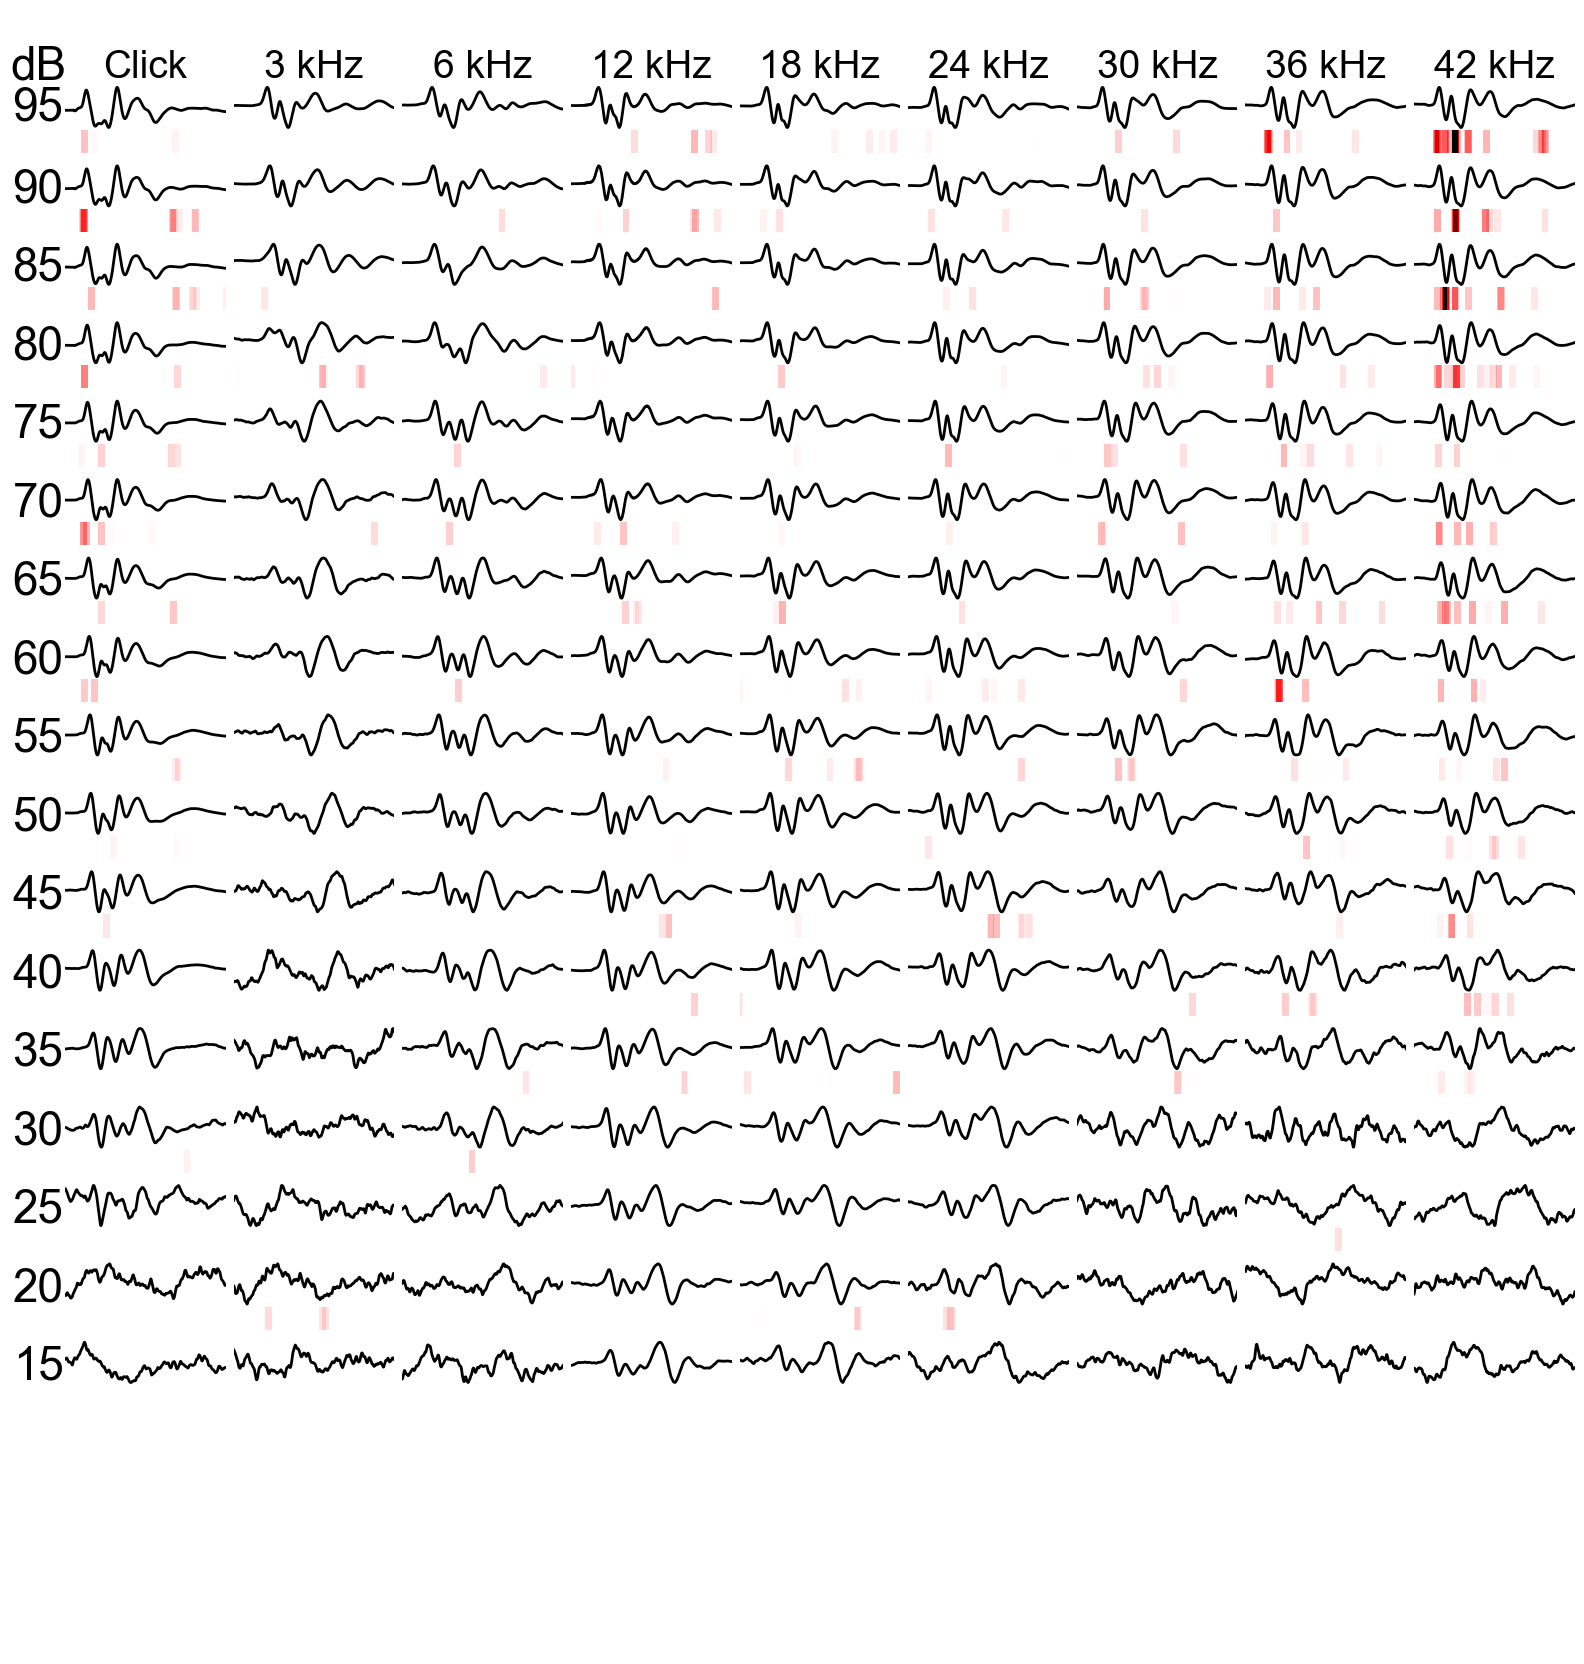

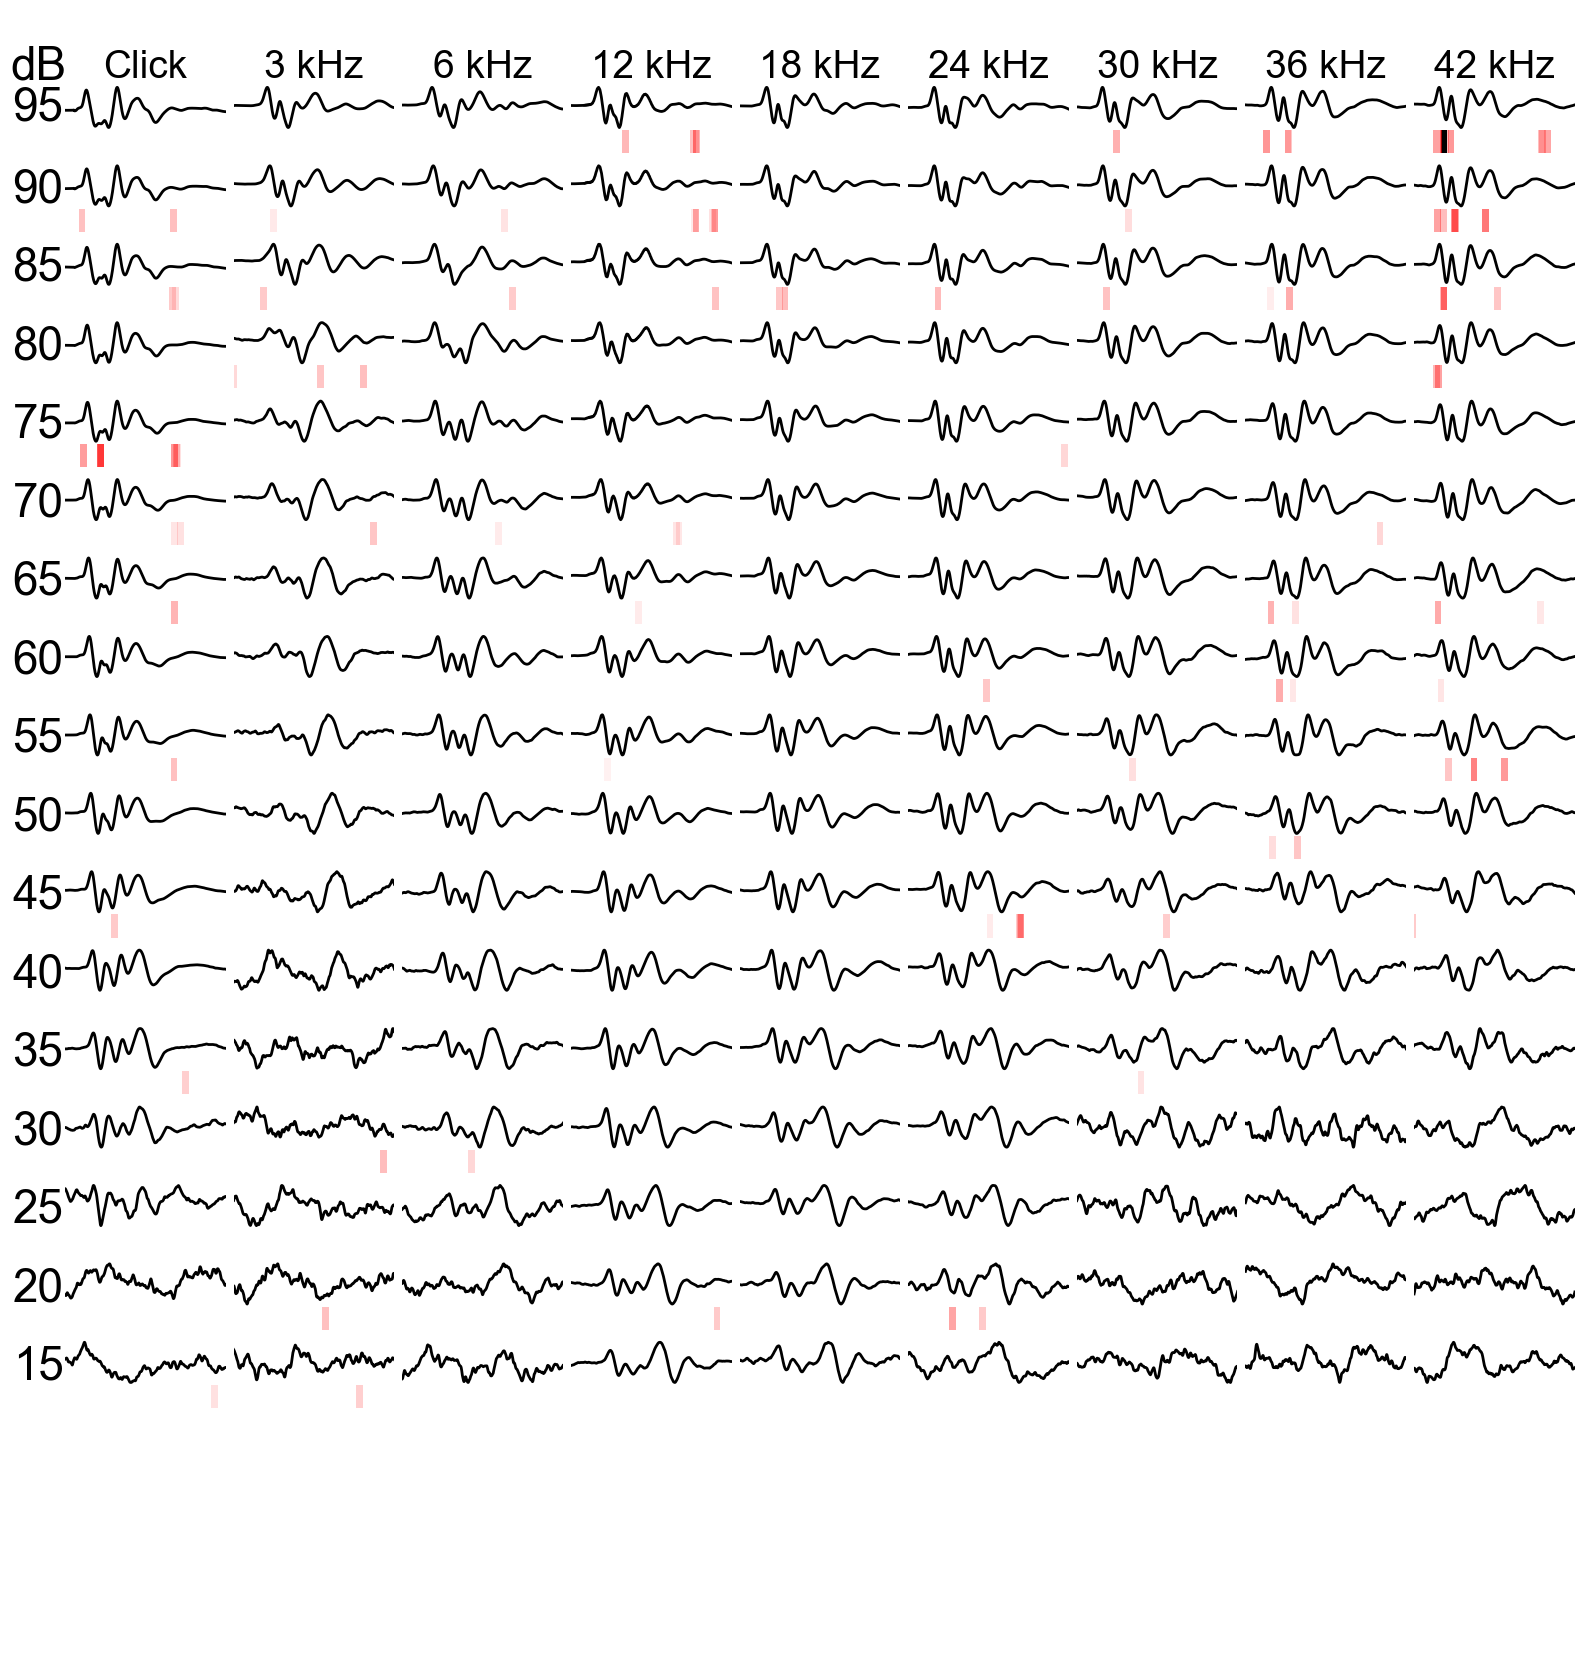

In [23]:
import joblib
savgolFilterOrder = 41

from matplotlib.colors import LinearSegmentedColormap


colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0, 0), (0,0,0)]  # white to light red to red
positions = [0, 0.1, 0.75,1]  # faster transition by moving middle point closer to start
cmap = LinearSegmentedColormap.from_list("custom_reds", list(zip(positions, colors)))

#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentGlobalShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
fig,axs = makeFigureFeatureImportance(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,fi,title=' ',linecolor='k',cmap=cmap,linewidth=2,alpha = 1,fontSize=33)

model_RF = joblib.load(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentGlobal.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((153,1953))

dd = abr.drop([(100,0),(100,5),(100,10),(18000,5),(18000,10)])

dd.values[~selected_features] = np.nan
dd

dd2 = abr.copy()

dd2.loc[dd.index] = dd

# fig, axs = makeFigureFeatureImportance( abr.reset_index().values[:,0],abr.reset_index().values[:,1], dd2.values, None, title=' ', linecolor='b', cmap=cmap, vmin=0, vmax=1,fig=fig,axs=axs,linewidth=2.1)
fig.savefig('./Panels/forest_shapley_Global.pdf',dpi=1200,transparent=True)




#XGBOOST forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'XGBOOST_kFoldCrossValidation_AnovaFS10percent_GlobalShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
fig,axs = makeFigureFeatureImportance(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,fi,title=' ',linecolor='k',cmap=cmap,alpha=1,linewidth=2,fontSize=33)

model_RF = joblib.load(os.path.join(resultFolder,'XGBOOST_kFoldCrossValidation_AnovaFS10percent_Global.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((153,1953))

dd = abr.drop([(100,0),(100,5),(100,10),(18000,5),(18000,10)])

dd.values[~selected_features] = np.nan
dd

dd2 = abr.copy()

dd2.loc[dd.index] = dd

# fig, axs = makeFigureFeatureImportance( abr.reset_index().values[:,0],abr.reset_index().values[:,1], dd2.values, None, title=' ', linecolor='b', cmap=cmap, vmin=0, vmax=1,fig=fig,axs=axs,linewidth=2.1)
fig.savefig('./Panels/xgb_shapley_Global.pdf',dpi=1200,transparent=True)




Average 

In [11]:
from matplotlib.colors import LinearSegmentedColormap


colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0, 0), (0,0,0)]  # white to light red to red
positions = [0, 0.1, 0.75,1]  # faster transition by moving middle point closer to start
cmap = LinearSegmentedColormap.from_list("custom_reds", list(zip(positions, colors)))

/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SelectPercentile from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


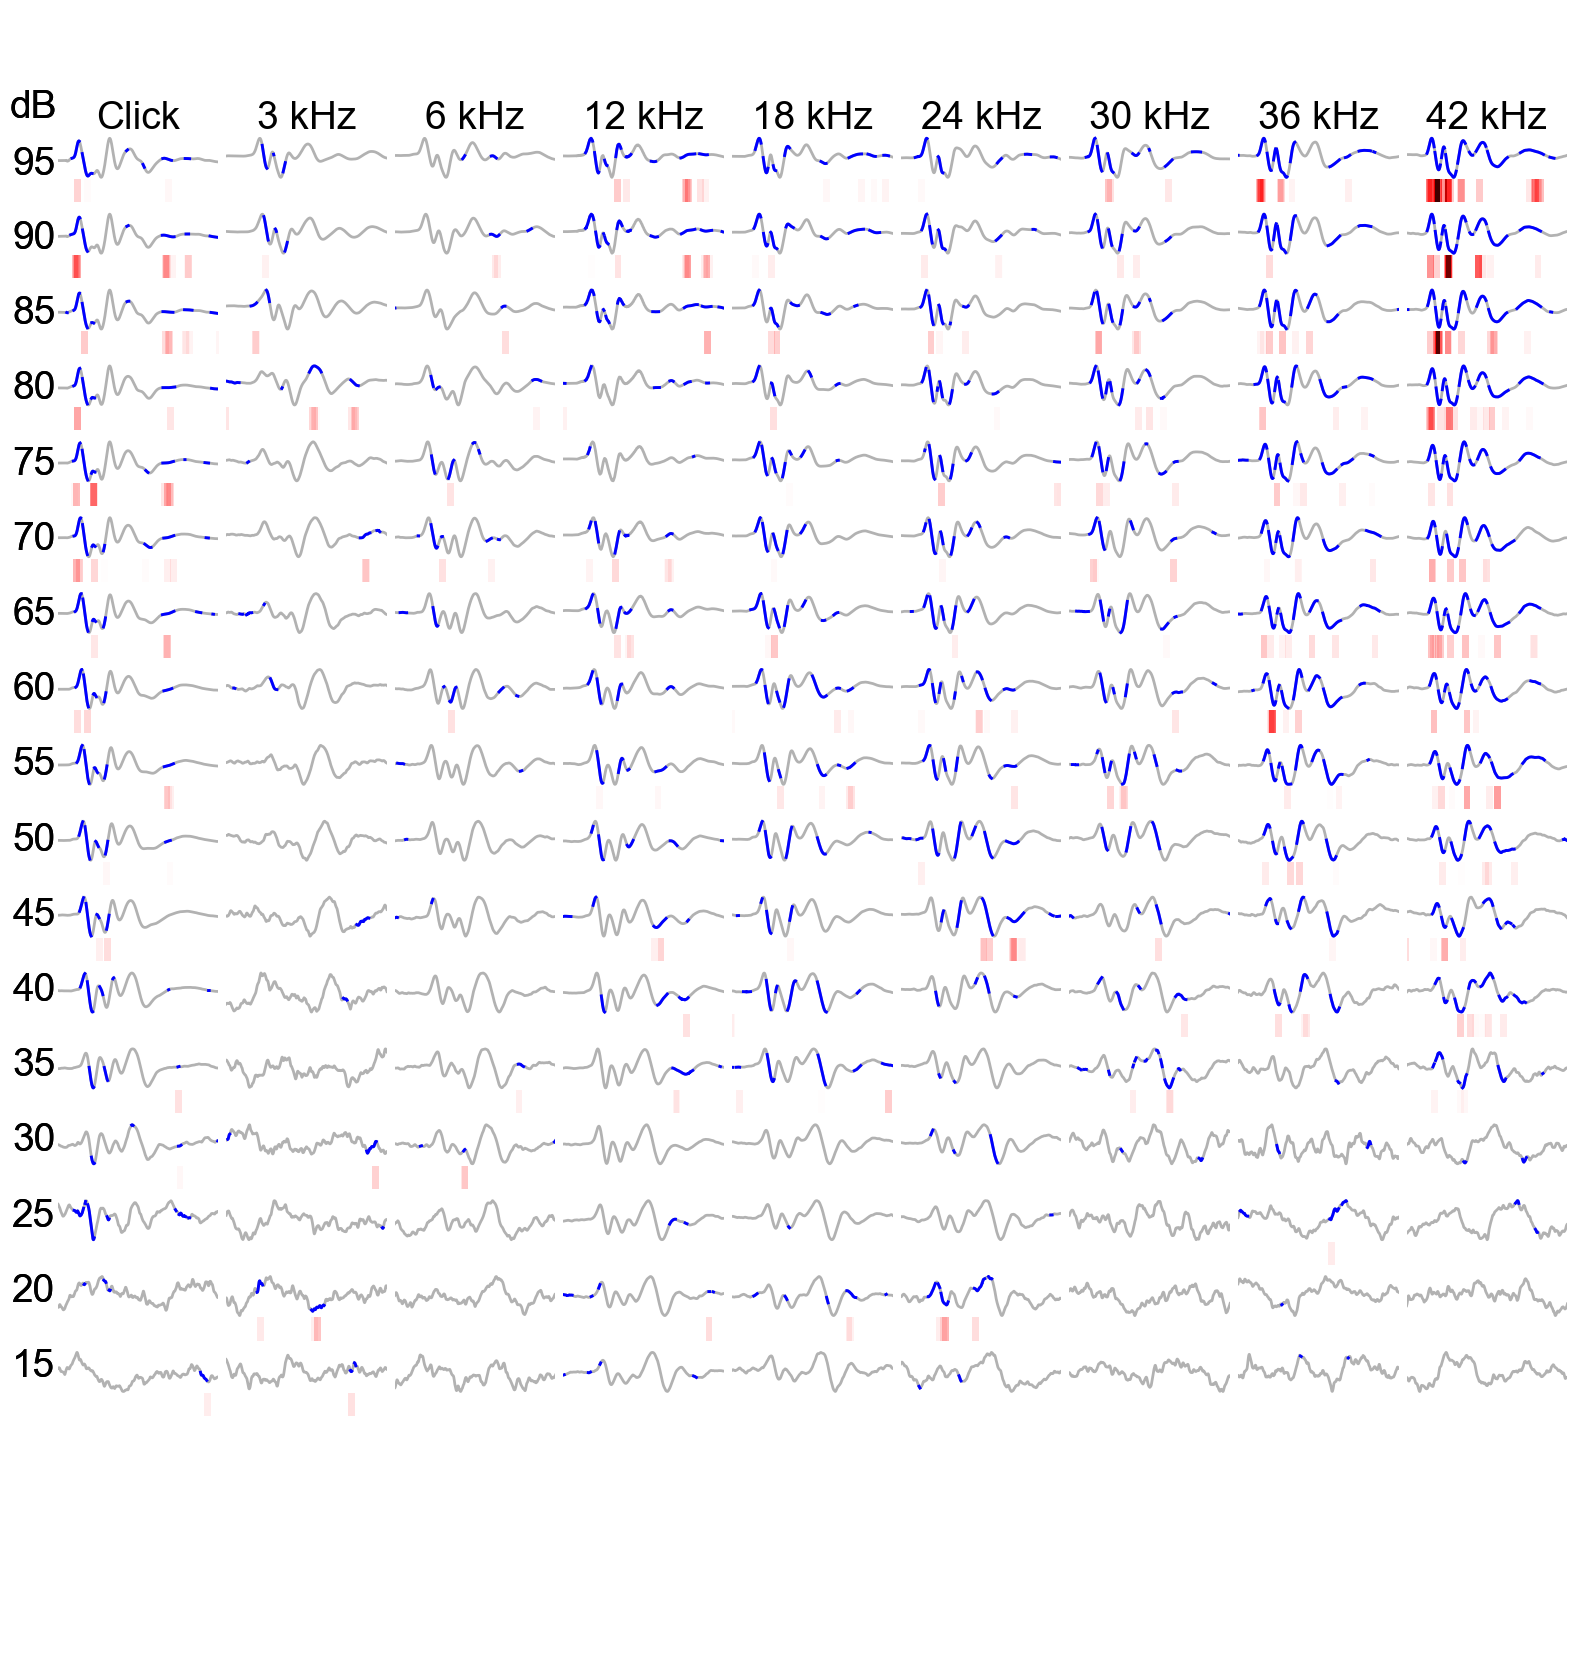

In [13]:
#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentGlobalShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
#XGBOOST forest 10%Anova Global
fixgb = pd.read_csv(os.path.join(resultFolder,'XGBOOST_kFoldCrossValidation_AnovaFS10percent_GlobalShapCoeff.csv'),index_col=0)
fixgb = abs(fixgb).mean(1).values
fixgb = savgol_filter(fixgb,savgolFilterOrder,1)


fi = (fi/fi.max()+fixgb/fixgb.max())/2
fig,axs = makeFigureFeatureImportance(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,fi,title=' ',linecolor='k',cmap=cmap,linewidth=2,alpha = 0.3)

model_RF = joblib.load(os.path.join(resultFolder,'XGBOOST_kFoldCrossValidation_AnovaFS10percent_Global.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((153,1953))

dd = abr.drop([(100,0),(100,5),(100,10),(18000,5),(18000,10)])

dd.values[~selected_features] = np.nan
dd

dd2 = abr.copy()

dd2.loc[dd.index] = dd

fig, axs = makeFigureFeatureImportance( abr.reset_index().values[:,0],abr.reset_index().values[:,1], dd2.values, None, title=' ', linecolor='b', cmap=cmap, vmin=0, vmax=1,fig=fig,axs=axs,linewidth=2.1)
fig.savefig('./Panels/xgb_shapley_Global.pdf',dpi=1200,transparent=True)



fig.savefig('./Panels/forest+xgboost_shapley_Global.pdf',dpi=1200,transparent=True)


Colorbar

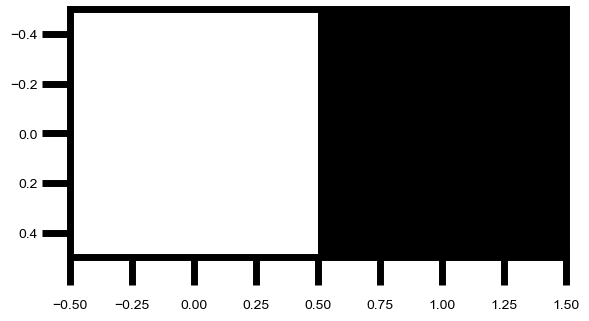

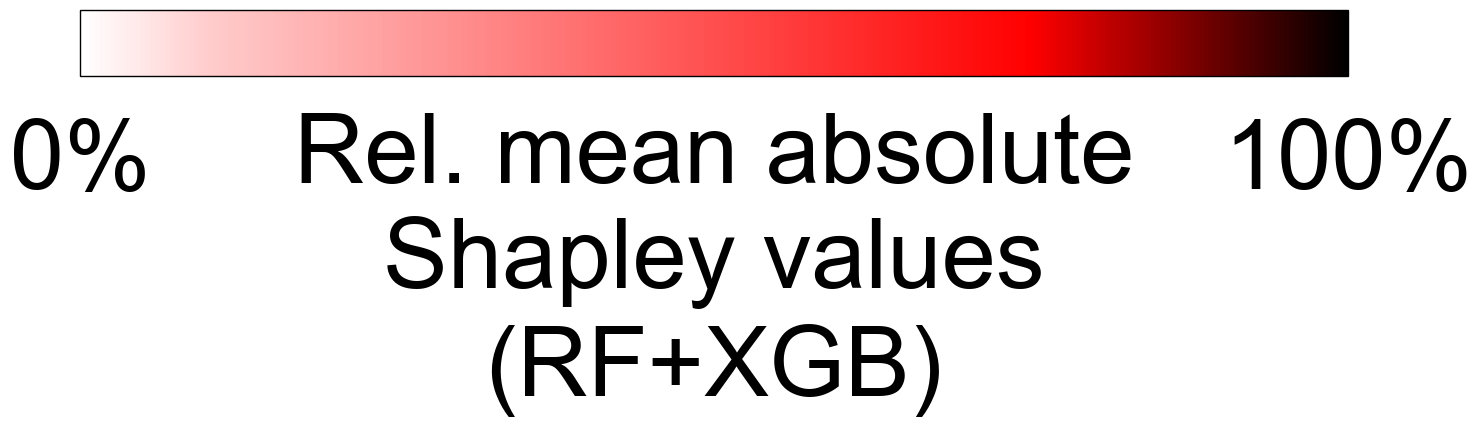

In [50]:
a = np.array([[0,1]])


img = imshow(a, cmap=cmap)
f=figure(figsize=(3.7*2.5*1.6138,3.7*2.5*1.2))
gs= gridspec.GridSpec(2,1,height_ratios=[10,1],hspace=0,figure=f)
#ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])



colorbar(orientation="horizontal", cax=ax2,mappable=img)
ax2.set_xticks([0,1],['0%','100%'])
ax2.set_xlabel('\nRel. mean absolute\nShapley values\n(RF+XGB)',rotation=0, va='center')

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize)
ax2.xaxis.set_tick_params(width=0)
[i.set_linewidth(1) for i in ax2.spines.values()]

gs.tight_layout(f)
f.savefig('./Panels/shapleyColorbar.pdf',dpi=1200,transparent=True)